<a href="https://colab.research.google.com/github/deborabmfreitas/coffee-shop-sales-prediction/blob/main/Aula_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula Prática de Aprendizado de Máquina

Neste notebook vamos aplicar **diferentes técnicas de pré-processamento** para comparar como impactam nos modelos de classificação e regressão.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.datasets import fetch_california_housing, load_breast_cancer

from copy import deepcopy

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
                             mean_absolute_error, mean_squared_error, r2_score)

import warnings
warnings.filterwarnings("ignore")

**Funções para avaliar os modelos**

In [ ]:
def avaliar_classificacao(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

def avaliar_regressao(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

## Parte 1 – Classificação com Diferentes Pré-processamentos

**1.1 Breast Cancer Dataset**

In [ ]:

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Simular 5% de valores ausentes
rng = np.random.default_rng(42)
mask = rng.choice([1, 0], size=X.shape, p=[.05, .95]).astype(bool)
X_missing = X.mask(mask)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_missing, y, test_size=0.3, random_state=42, stratify=y
)

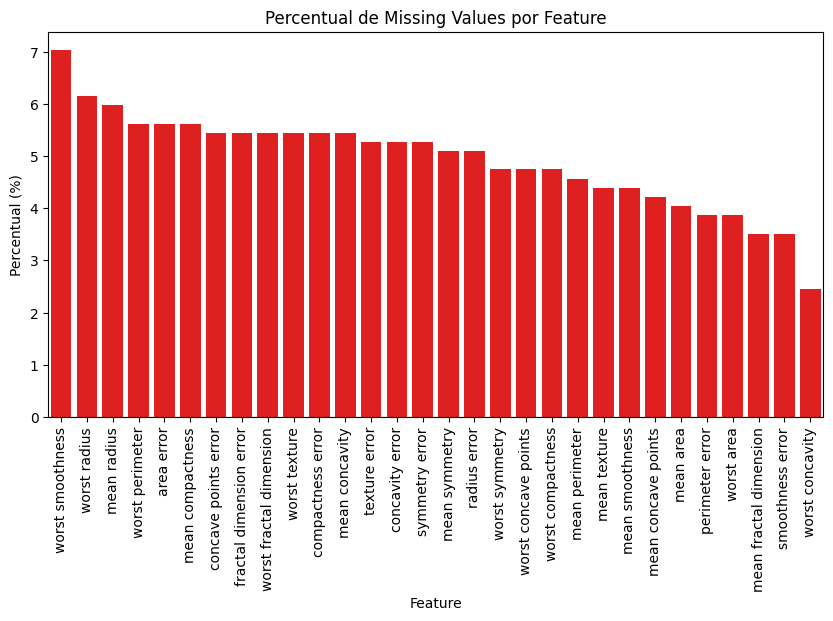

Resumo de Missing Values:
                         Missing Count  Missing %
worst smoothness                    40   7.029877
worst radius                        35   6.151142
mean radius                         34   5.975395
worst perimeter                     32   5.623902
area error                          32   5.623902
mean compactness                    32   5.623902
concave points error                31   5.448155
fractal dimension error             31   5.448155
worst fractal dimension             31   5.448155
worst texture                       31   5.448155


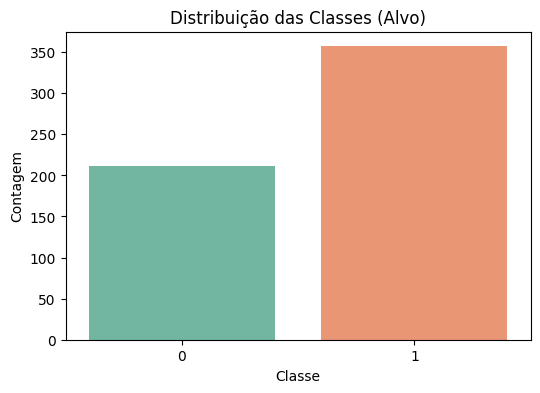

Distribuição das classes:
1    0.627417
0    0.372583
Name: proportion, dtype: float64


In [ ]:
# Análise de Missing Values

missing_counts = X_missing.isnull().sum()
missing_percent = (missing_counts / len(X_missing)) * 100
missing_df = pd.DataFrame({"Missing Count": missing_counts, "Missing %": missing_percent})
missing_df = missing_df[missing_df["Missing Count"] > 0].sort_values("Missing Count", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df["Missing %"], color="red")
plt.xticks(rotation=90)
plt.title("Percentual de Missing Values por Feature")
plt.ylabel("Percentual (%)")
plt.xlabel("Feature")
plt.show()

print("Resumo de Missing Values:")
print(missing_df.head(10))  # mostra as top features com mais missing

# Análise de Desbalanceamento das Classes

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="Set2")
plt.title("Distribuição das Classes (Alvo)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

print("Distribuição das classes:")
print(y.value_counts(normalize=True))

**1.2 Abalone**

In [ ]:
import pandas as pd

# carregando o dataset
data = pd.read_csv("https://raw.githubusercontent.com/cynthiamaia/Monitoria-DeepLearning-CIN-AI/main/Datasets/abalone.csv")

<Axes: xlabel='Rings', ylabel='count'>

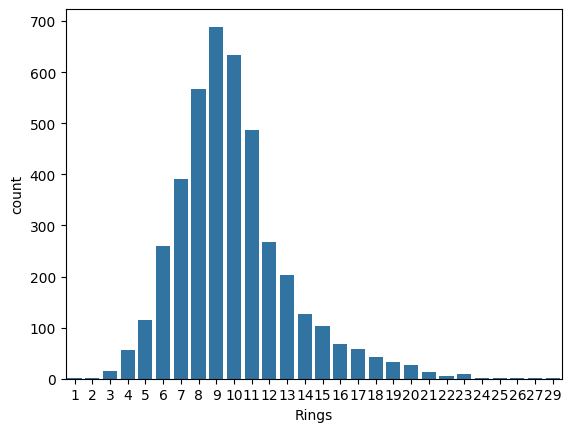

In [ ]:
sns.countplot(x="Rings", data=data)

(3727, 9)


<Axes: xlabel='Rings', ylabel='Rings'>

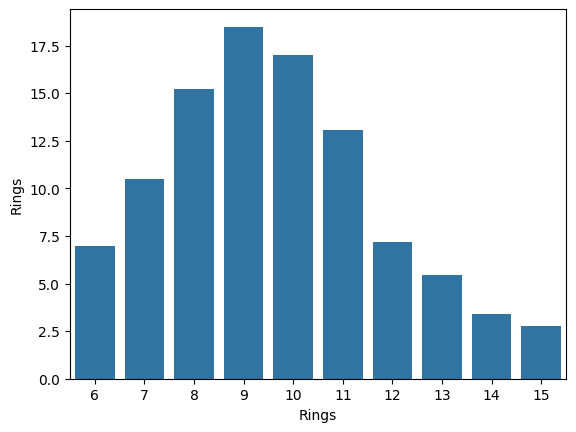

In [ ]:
data = data.loc[(data["Rings"]>5) & (data["Rings"]<16)]

print(data.shape)

#percentual
sns.barplot(x="Rings", y="Rings",  data=data,  estimator=lambda x: len(x) / len(data) * 100)

In [ ]:
# adicionar NaNs na coluna numérica "Length"
np.random.seed(42)
missing_idx = np.random.choice(data.index, size=20, replace=False)
data.loc[missing_idx, "Length"] = np.nan

# adicionar NaNs na coluna categórica "Sex"
missing_idx = np.random.choice(data.index, size=10, replace=False)
data.loc[missing_idx, "Sex"] = np.nan

# verificar quantos faltantes agora tem
print(data.isnull().sum())
print(data.head(15))

Rings             0
Sex              10
Length           20
Diameter          0
Height            0
WholeWeight       0
ShuckedWeight     0
VisceraWeight     0
ShellWeight       0
dtype: int64
    Rings  Sex  Length  Diameter  Height  WholeWeight  ShuckedWeight  \
0      15  0.0   0.455     0.365   0.095       0.5140         0.2245   
1       7  0.0   0.350     0.265   0.090       0.2255         0.0995   
2       9  1.0   0.530     0.420   0.135       0.6770         0.2565   
3      10  0.0   0.440     0.365   0.125       0.5160         0.2155   
4       7  2.0   0.330     0.255   0.080       0.2050         0.0895   
5       8  2.0   0.425     0.300   0.095       0.3515         0.1410   
8       9  0.0   0.475     0.370   0.125       0.5095         0.2165   
10     14  1.0   0.525     0.380   0.140       0.6065         0.1940   
11     10  0.0   0.430     0.350   0.110       0.4060         0.1675   
12     11  0.0   0.490     0.380   0.135       0.5415         0.2175   
13     10  1.0 

In [ ]:
X = data.iloc[:,1:8]
y = data.iloc[:,0]

# Introduzir valores ausentes artificialmente
rng = np.random.default_rng(42)
mask = rng.choice([1,0], size=X.shape, p=[.05, .95]).astype(bool)
X_missing = X.mask(mask)

X_train, X_test, y_train, y_test = train_test_split(X_missing, y, test_size=0.3, random_state=42, stratify=y)

# **Pipeline**

In [ ]:
# Definição de pré-processamentos
preprocessamentos = {
    "Sem Tratamento": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0))
    ]),
    "Imputação + StandardScaler": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]),
    "Imputação + MinMaxScaler": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler())
    ]),
    "Imputação + Normalizer": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("normalizer", Normalizer())
    ]),
    "Imputação + StandardScaler + PCA (5 comp.)": Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5))
    ])
}

# Definição de modelos

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=500)
}

# Loop para avaliar todos os preprocessamentos + modelos

resultados_classificacao = {}

for nome_prep, prep_pipeline in preprocessamentos.items():
    resultados_classificacao[nome_prep] = {}

    # aplica o pipeline de pré-processamento
    Xtr = prep_pipeline.fit_transform(X_train)
    Xte = prep_pipeline.transform(X_test)

    for nome_modelo, modelo in modelos.items():
        resultados_classificacao[nome_prep][nome_modelo] = avaliar_classificacao(
            modelo, Xtr, Xte, y_train, y_test
        )

# DataFrame final de resultados
df_classificacao = pd.concat(
    {k: pd.DataFrame(v).T for k, v in resultados_classificacao.items()}
)

df_classificacao

Accuracy  \
Sem Tratamento                             Logistic Regression  0.877193   
                                           KNN                  0.912281   
                                           Decision Tree        0.918129   
                                           Random Forest        0.923977   
                                           Naive Bayes          0.929825   
                                           MLP                  0.900585   
Imputação + StandardScaler                 Logistic Regression  0.964912   
                                           KNN                  0.953216   
                                           Decision Tree        0.935673   
                                           Random Forest        0.929825   
                                           Naive Bayes          0.929825   
                                           MLP                  0.970760   
Imputação + MinMaxScaler                   Logistic Regression  0.947368   
                                           KNN                  0.964912   
                                           Decision Tree        0.929825   
                                           Random Forest        0.923977   
                                           Naive Bayes          0.929825   
                                           MLP                  0.982456   
Imputação + Normalizer                     Logistic Regression  0.701754   
                                           KNN                  0.853801   
                                           Decision Tree        0.877193   
                                           Random Forest        0.929825   
                                           Naive Bayes          0.777778   
                                           MLP                  0.888889   
Imputação + StandardScaler + PCA (5 comp.) Logistic Regression  0.964912   
                                           KNN                  0.935673   
                                           Decision Tree        0.929825   
                                           Random Forest        0.953216   
                                           Naive Bayes          0.923977   
                                           MLP                  0.959064   

                                                                Precision  \
Sem Tratamento                             Logistic Regression   0.877193   
                                           KNN                   0.912064   
                                           Decision Tree         0.918878   
                                           Random Forest         0.924275   
                                           Naive Bayes           0.929951   
                                           MLP                   0.900330   
Imputação + StandardScaler                 Logistic Regression   0.965398   
                                           KNN                   0.954785   
                                           Decision Tree         0.936831   
                                           Random Forest         0.929825   
                                           Naive Bayes           0.929632   
                                           MLP                   0.971639   
Imputação + MinMaxScaler                   Logistic Regression   0.948205   
                                           KNN                   0.965576   
                                           Decision Tree         0.931668   
                                           Random Forest         0.924275   
                                           Naive Bayes           0.929632   
                                           MLP                   0.982581   
Imputação + Normalizer                     Logistic Regression   0.756872   
                                           KNN                   0.852870   
                                           Decision Tree         0.878817   
             

In [ ]:
# Estratégias de balanceamento
estrategias = {
    "Sem Balanceamento": None,
    "Oversample": RandomOverSampler(random_state=42),
    "Undersample": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}

# Pré-processamentos em cascata
preprocessamentos = {
    "Sem Tratamento": [("imputer", SimpleImputer(strategy="constant", fill_value=0))],
    "Imputação + StandardScaler": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ],
    "Imputação + MinMaxScaler": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler())
    ],
    "Imputação + Normalizer": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("normalizer", Normalizer())
    ],
    "Imputação + StandardScaler + PCA (7 comp.)": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=7))
    ]
}

# Modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=500)
}

# Combinando estratégias + preprocessamentos + modelos
resultados_classificacao = {}

for nome_estrat, sampler in estrategias.items():
    resultados_classificacao[nome_estrat] = {}

    for nome_prep, steps_prep in preprocessamentos.items():
        resultados_classificacao[nome_estrat][nome_prep] = {}

        for nome_modelo, modelo in modelos.items():
            if sampler is not None:
                pipeline = ImbPipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                                              ("sampler", sampler)]
                                              + steps_prep[1:]
                                              + [("clf", deepcopy(modelo))])
            else:
                pipeline = Pipeline(steps=steps_prep + [("clf", deepcopy(modelo))])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            resultados_classificacao[nome_estrat][nome_prep][nome_modelo] = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "F1-Score": f1_score(y_test, y_pred, average="weighted", zero_division=0)
            }

# DataFrame Resultados
df_classificacao_completa = pd.concat({
    estrat: pd.concat({prep: pd.DataFrame(modelos_res).T
                       for prep, modelos_res in prep_dict.items()})
    for estrat, prep_dict in resultados_classificacao.items()
})

df_classificacao_completa

Accuracy  \
Sem Balanceamento Sem Tratamento                             Logistic Regression  0.877193   
                                                             KNN                  0.912281   
                                                             Decision Tree        0.918129   
                                                             Random Forest        0.923977   
                                                             Naive Bayes          0.929825   
...                                                                                    ...   
SMOTE             Imputação + StandardScaler + PCA (7 comp.) KNN                  0.941520   
                                                             Decision Tree        0.935673   
                                                             Random Forest        0.959064   
                                                             Naive Bayes          0.947368   
                                                             MLP                  0.947368   

                                                                                  Precision  \
Sem Balanceamento Sem Tratamento                             Logistic Regression   0.877193   
                                                             KNN                   0.912064   
                                                             Decision Tree         0.918878   
                                                             Random Forest         0.924275   
                                                             Naive Bayes           0.929951   
...                                                                                     ...   
SMOTE             Imputação + StandardScaler + PCA (7 comp.) KNN                   0.942138   
                                                             Decision Tree         0.936831   
                                                             Random Forest         0.961320   
                                                             Naive Bayes           0.947598   
                                                             MLP                   0.951572   

                                                                                    Recall  \
Sem Balanceamento Sem Tratamento                             Logistic Regression  0.877193   
                                                             KNN                  0.912281   
                                                             Decision Tree        0.918129   
                                                             Random Forest        0.923977   
                                                             Naive Bayes          0.929825   
...                                                                                    ...   
SMOTE             Imputação + StandardScaler + PCA (7 comp.) KNN                  0.941520   
                                                             Decision Tree        0.935673   
                                                             Random Forest        0.959064   
                                                             Naive Bayes          0.947368   
                                                             MLP                  0.947368   

                                                                                  F1-Score  
Sem Balanceamento Sem Tratamento                             Logistic Regression  0.875586  
                                                             KNN                  0.912139  
                                                             Decision Tree        0.918372  
                                                             Random Forest        0.924093  
                                                             Naive Bayes          0.929337  
...                                                                                    ...  
SMOTE             Imputação + St

## Parte 2 – Regressão com Diferentes Pré-processamentos

**2.1 California Housing Dataset**

In [ ]:
# Dataset com missing artificial
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.Series(housing.target)

# Inserindo 5% de missing aleatório
rng = np.random.default_rng(42)
mask = rng.choice([1,0], size=X.shape, p=[.05, .95]).astype(bool)
X_missing = X.mask(mask)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_missing, y, test_size=0.3, random_state=42
)

# Pré-processamentos em cascata

preprocessamentos_reg = {
    "Sem Tratamento": [("imputer", SimpleImputer(strategy="constant", fill_value=0))],
    "Imputação Média": [("imputer", SimpleImputer(strategy="mean"))],
    "StandardScaler": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ],
    "MinMaxScaler": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler())
    ],
    "Normalizer": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("normalizer", Normalizer())
    ],
    "PCA (5 comp.)": [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5))
    ]
}

# Modelos de Regressão

modelos_reg = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "MLP Regressor": MLPRegressor(max_iter=500)
}

# Loop avaliando preprocessamentos + modelos

resultados_regressao = {}

for nome_prep, steps_prep in preprocessamentos_reg.items():
    resultados_regressao[nome_prep] = {}

    for nome_modelo, modelo in modelos_reg.items():
        pipeline = Pipeline(steps=steps_prep + [("reg", modelo)])

        resultados_regressao[nome_prep][nome_modelo] = avaliar_regressao(
            pipeline, X_train, X_test, y_train, y_test
        )


# DataFrame final

df_regressao = pd.concat(
    {k: pd.DataFrame(v).T for k, v in resultados_regressao.items()}
)

df_regressao

MAE      RMSE        R²
Sem Tratamento  Linear Regression  0.675421  0.895541  0.388976
                Decision Tree      0.504660  0.776214  0.540960
                Random Forest      0.374387  0.558561  0.762301
                MLP Regressor      1.518181  2.065263 -2.249660
Imputação Média Linear Regression  0.574790  0.806584  0.504337
                Decision Tree      0.515657  0.795303  0.518105
                Random Forest      0.365931  0.548613  0.770692
                MLP Regressor      0.586591  0.797478  0.515465
StandardScaler  Linear Regression  0.574790  0.806584  0.504337
                Decision Tree      0.514113  0.791497  0.522706
                Random Forest      0.365489  0.548661  0.770651
                MLP Regressor      0.417251  0.610198  0.716320
MinMaxScaler    Linear Regression  0.574790  0.806584  0.504337
                Decision Tree      0.517510  0.801165  0.510974
                Random Forest      0.364703  0.549191  0.770208
                MLP Regressor      0.435614  0.633887  0.693866
Normalizer      Linear Regression  0.770661  1.002089  0.234933
                Decision Tree      0.698365  0.980622  0.267360
                Random Forest      0.514080  0.711816  0.613968
                MLP Regressor      0.562684  0.748336  0.573341
PCA (5 comp.)   Linear Regression  0.653825  0.871412  0.421458
                Decision Tree      0.770184  1.093941  0.088251
                Random Forest      0.555982  0.772487  0.545358
                MLP Regressor      0.550286  0.760562  0.559286